# 第一个典型的CNN是LeNet5网络结构，但是第一个引起大家注意的网络却是AlexNet，也就是文章《ImageNet Classification with Deep Convolutional Neural Networks》介绍的网络结构。这篇文章的网络是在2012年的ImageNet竞赛中取得冠军的一个模型整理后发表的文章。
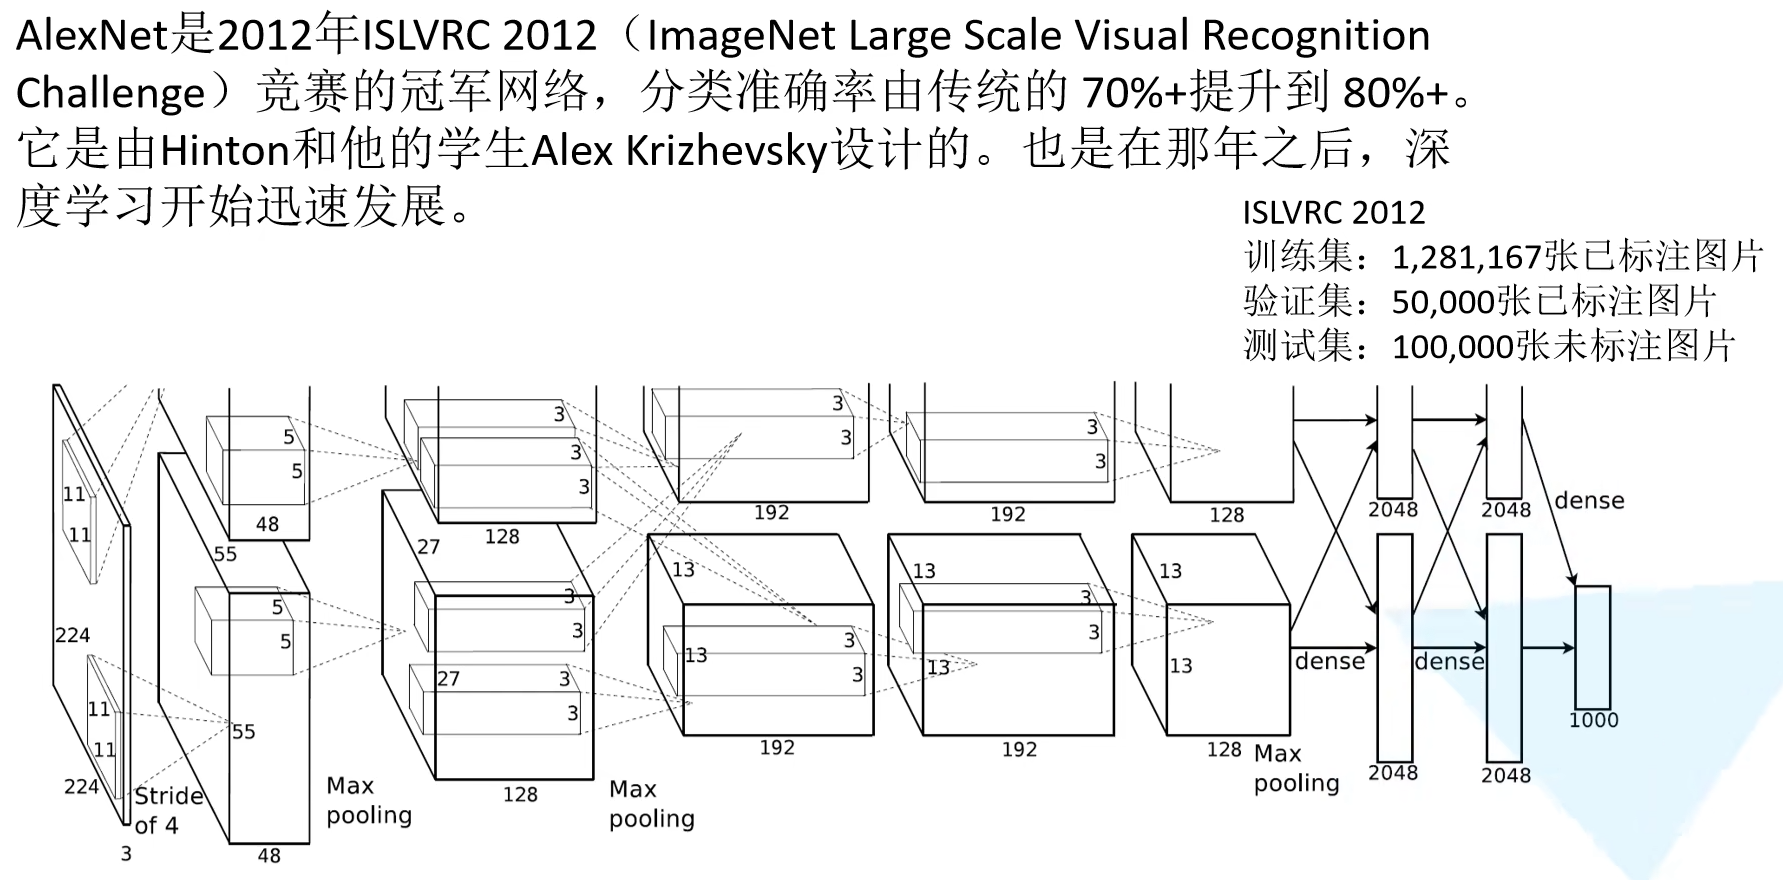

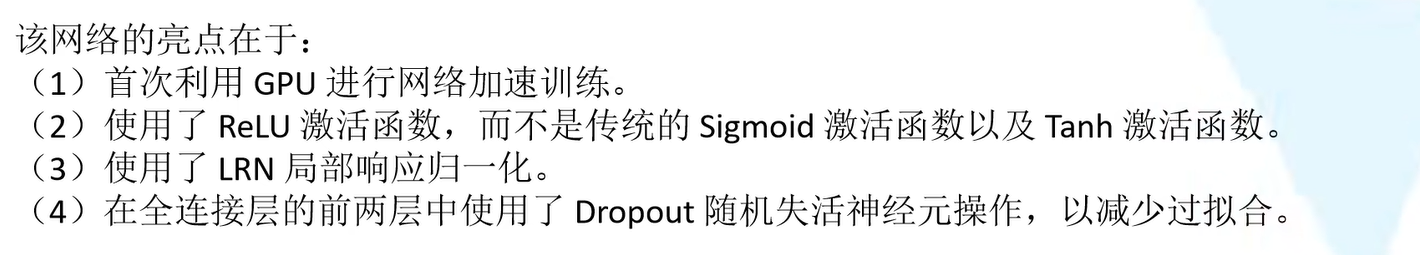

# 网络模型

In [1]:
import torch.nn as nn
import torch

class AlexNet(nn.Module):
    def __init__(self, num_classes=1000, init_weights=False):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(              #为了加快速度将参数减半，准确率影响不大
            nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=2),  # input[3, 224, 224]  output[48, 55, 55]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[48, 27, 27]
            nn.Conv2d(48, 128, kernel_size=5, padding=2),           # output[128, 27, 27]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[128, 13, 13]
            nn.Conv2d(128, 192, kernel_size=3, padding=1),          # output[192, 13, 13]
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),          # output[192, 13, 13]
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 128, kernel_size=3, padding=1),          # output[128, 13, 13]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[128, 6, 6]
        )
        self.classifier = nn.Sequential(                            #分类器
            nn.Dropout(p=0.5),
            nn.Linear(128 * 6 * 6, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


D:\ANnaconda\envs\HBHB\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 训练模块

In [2]:
import os
import sys
import json

import torch
import torch.nn as nn
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from tqdm import tqdm



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),  #随机裁剪
                                 transforms.RandomHorizontalFlip(),  #随即翻转    为了数据增强
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((224, 224)),  # cannot 224, must (224, 224)
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

image_path =  "../data/flower_data"

train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                     transform=data_transform["train"])
train_num = len(train_dataset)


# {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
flower_list = train_dataset.class_to_idx                               #字典方式存放标签
cla_dict = dict((val, key) for key, val in flower_list.items())        #键和值互换

# write dict into json file  方便预测时读取标签
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)


#-------------------------------------------------------------------------------------------------
batch_size = 32
#nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])    # number of workers
# print('Using {} dataloader workers every process'.format(nw))

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True,num_workers=0)

validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"),transform=data_transform["val"])
val_num = len(validate_dataset)
validate_loader = torch.utils.data.DataLoader(validate_dataset,batch_size=batch_size, shuffle=False,num_workers=0)

print("using {} images for training, {} images for validation.".format(train_num,val_num))

'''
查看数据集的代码
# test_data_iter = iter(validate_loader)
# test_image, test_label = test_data_iter.next()
#
# def imshow(img):
#     img = img / 2 + 0.5  # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()
#
# print(' '.join('%5s' % cla_dict[test_label[j].item()] for j in range(4)))
# imshow(utils.make_grid(test_image))
'''
net = AlexNet(num_classes=5, init_weights=True)

net.to(device)
loss_function = nn.CrossEntropyLoss()
# pata = list(net.parameters())
optimizer = optim.Adam(net.parameters(), lr=0.0002)

epochs = 30
save_path = './AlexNet.pth'
best_acc = 0.0
train_steps = len(train_loader)
for epoch in range(epochs):
    # train
    net.train()   #管理dropout层(只在正向传播使用)，等等。。
    running_loss = 0.0   #平均损失
#     train_bar = tqdm(train_loader, file=sys.stdout)
    
    for step, data in enumerate(train_loader,start=0):
        images, labels = data
        optimizer.zero_grad()                           #梯度清零
        outputs = net(images.to(device))                #正向传播
        loss = loss_function(outputs, labels.to(device))#计算损失
        loss.backward()                                 #反向传播
        optimizer.step()                                #优化器更新参数

        # print statistics
        running_loss += loss.item()                     #统计损失
        #打印训练进度
        print("train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,epochs,loss))

    # validate
    net.eval()                               #管理dropout层(只在正向传播使用)，等等。。
    acc = 0.0                                # accumulate accurate number / epoch
    with torch.no_grad():                    #禁止pytorch对参数跟踪，不计算下面操作的梯度
#         val_bar = tqdm(validate_loader, file=sys.stdout)
        for val_data in validate_loader:
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

    val_accurate = acc / val_num
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %(epoch + 1, running_loss / train_steps, val_accurate))

    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(net.state_dict(), save_path)

print('Finished Training')


using cuda:0 device.
using 3306 images for training, 364 images for validation.
train epoch[1/30] loss:1.609
train epoch[1/30] loss:1.609
train epoch[1/30] loss:1.618
train epoch[1/30] loss:1.582
train epoch[1/30] loss:1.606
train epoch[1/30] loss:1.648
train epoch[1/30] loss:1.648
train epoch[1/30] loss:1.634
train epoch[1/30] loss:1.594
train epoch[1/30] loss:1.607
train epoch[1/30] loss:1.602
train epoch[1/30] loss:1.604
train epoch[1/30] loss:1.573
train epoch[1/30] loss:1.583
train epoch[1/30] loss:1.505
train epoch[1/30] loss:1.504
train epoch[1/30] loss:1.418
train epoch[1/30] loss:1.527
train epoch[1/30] loss:1.456
train epoch[1/30] loss:1.455
train epoch[1/30] loss:1.367
train epoch[1/30] loss:1.389
train epoch[1/30] loss:1.291
train epoch[1/30] loss:1.348
train epoch[1/30] loss:1.555
train epoch[1/30] loss:1.275
train epoch[1/30] loss:1.335
train epoch[1/30] loss:1.270
train epoch[1/30] loss:1.408
train epoch[1/30] loss:1.404
train epoch[1/30] loss:1.553
train epoch[1/30] los

train epoch[3/30] loss:1.064
train epoch[3/30] loss:1.113
train epoch[3/30] loss:1.121
train epoch[3/30] loss:1.130
train epoch[3/30] loss:0.944
train epoch[3/30] loss:0.935
train epoch[3/30] loss:0.917
train epoch[3/30] loss:0.921
train epoch[3/30] loss:0.801
train epoch[3/30] loss:1.030
train epoch[3/30] loss:1.085
train epoch[3/30] loss:1.238
train epoch[3/30] loss:0.960
train epoch[3/30] loss:1.027
train epoch[3/30] loss:1.214
train epoch[3/30] loss:0.912
train epoch[3/30] loss:1.346
train epoch[3/30] loss:1.006
train epoch[3/30] loss:1.006
train epoch[3/30] loss:1.283
train epoch[3/30] loss:1.186
train epoch[3/30] loss:0.865
train epoch[3/30] loss:1.038
train epoch[3/30] loss:0.961
train epoch[3/30] loss:0.965
train epoch[3/30] loss:1.081
train epoch[3/30] loss:0.916
train epoch[3/30] loss:0.920
train epoch[3/30] loss:0.767
train epoch[3/30] loss:1.098
train epoch[3/30] loss:1.103
train epoch[3/30] loss:1.246
train epoch[3/30] loss:1.130
train epoch[3/30] loss:1.139
train epoch[3/

train epoch[6/30] loss:0.815
train epoch[6/30] loss:0.835
train epoch[6/30] loss:0.862
train epoch[6/30] loss:0.981
train epoch[6/30] loss:0.973
train epoch[6/30] loss:0.782
train epoch[6/30] loss:0.685
train epoch[6/30] loss:0.855
train epoch[6/30] loss:0.986
train epoch[6/30] loss:0.989
train epoch[6/30] loss:1.139
train epoch[6/30] loss:0.879
train epoch[6/30] loss:0.997
train epoch[6/30] loss:1.213
train epoch[6/30] loss:0.958
train epoch[6/30] loss:1.055
train epoch[6/30] loss:1.520
train epoch[6/30] loss:0.729
train epoch[6/30] loss:1.119
train epoch[6/30] loss:1.054
train epoch[6/30] loss:0.928
train epoch[6/30] loss:0.788
train epoch[6/30] loss:1.051
train epoch[6/30] loss:1.051
train epoch[6/30] loss:0.848
train epoch[6/30] loss:1.024
train epoch[6/30] loss:1.100
train epoch[6/30] loss:0.941
train epoch[6/30] loss:1.106
train epoch[6/30] loss:0.913
train epoch[6/30] loss:0.805
train epoch[6/30] loss:0.776
train epoch[6/30] loss:0.783
train epoch[6/30] loss:0.675
train epoch[6/

train epoch[9/30] loss:0.691
train epoch[9/30] loss:0.771
train epoch[9/30] loss:0.797
train epoch[9/30] loss:0.699
train epoch[9/30] loss:0.830
train epoch[9/30] loss:0.588
train epoch[9/30] loss:0.791
train epoch[9/30] loss:0.816
train epoch[9/30] loss:1.076
train epoch[9/30] loss:0.573
train epoch[9/30] loss:0.937
train epoch[9/30] loss:1.044
train epoch[9/30] loss:0.807
train epoch[9/30] loss:0.827
train epoch[9/30] loss:0.780
train epoch[9/30] loss:0.901
train epoch[9/30] loss:0.882
train epoch[9/30] loss:0.950
train epoch[9/30] loss:0.957
train epoch[9/30] loss:0.862
train epoch[9/30] loss:0.608
train epoch[9/30] loss:0.883
train epoch[9/30] loss:0.763
train epoch[9/30] loss:0.816
train epoch[9/30] loss:0.724
train epoch[9/30] loss:0.786
train epoch[9/30] loss:0.749
train epoch[9/30] loss:0.874
train epoch[9/30] loss:0.504
train epoch[9/30] loss:0.767
train epoch[9/30] loss:0.729
train epoch[9/30] loss:0.861
train epoch[9/30] loss:0.749
train epoch[9/30] loss:0.536
train epoch[9/

train epoch[11/30] loss:0.874
train epoch[11/30] loss:0.630
train epoch[11/30] loss:0.989
train epoch[11/30] loss:0.520
train epoch[11/30] loss:0.682
train epoch[11/30] loss:0.742
train epoch[11/30] loss:0.639
train epoch[11/30] loss:0.675
train epoch[11/30] loss:1.042
train epoch[11/30] loss:0.816
train epoch[11/30] loss:0.690
train epoch[11/30] loss:1.006
train epoch[11/30] loss:1.030
train epoch[11/30] loss:0.867
train epoch[11/30] loss:0.805
train epoch[11/30] loss:0.831
train epoch[11/30] loss:0.992
train epoch[11/30] loss:0.903
train epoch[11/30] loss:1.071
train epoch[11/30] loss:0.743
train epoch[11/30] loss:0.834
train epoch[11/30] loss:0.498
train epoch[11/30] loss:0.776
train epoch[11/30] loss:1.025
train epoch[11/30] loss:0.663
train epoch[11/30] loss:0.510
train epoch[11/30] loss:0.702
train epoch[11/30] loss:0.869
train epoch[11/30] loss:0.928
train epoch[11/30] loss:0.682
train epoch[11/30] loss:1.007
train epoch[11/30] loss:0.712
train epoch[11/30] loss:1.039
train epoc

train epoch[14/30] loss:0.967
train epoch[14/30] loss:0.936
train epoch[14/30] loss:0.688
train epoch[14/30] loss:0.824
train epoch[14/30] loss:0.691
train epoch[14/30] loss:0.945
train epoch[14/30] loss:0.955
train epoch[14/30] loss:0.924
train epoch[14/30] loss:0.942
train epoch[14/30] loss:0.629
train epoch[14/30] loss:0.690
train epoch[14/30] loss:0.856
train epoch[14/30] loss:1.250
train epoch[14/30] loss:0.899
train epoch[14/30] loss:0.823
train epoch[14/30] loss:0.950
train epoch[14/30] loss:0.771
train epoch[14/30] loss:0.770
train epoch[14/30] loss:0.893
train epoch[14/30] loss:0.958
train epoch[14/30] loss:0.962
train epoch[14/30] loss:0.872
train epoch[14/30] loss:0.752
train epoch[14/30] loss:0.690
train epoch[14/30] loss:0.892
train epoch[14/30] loss:0.688
train epoch[14/30] loss:0.518
train epoch[14/30] loss:0.931
train epoch[14/30] loss:0.646
train epoch[14/30] loss:0.944
train epoch[14/30] loss:0.550
train epoch[14/30] loss:0.697
train epoch[14/30] loss:0.976
train epoc

train epoch[16/30] loss:0.625
train epoch[16/30] loss:0.633
train epoch[16/30] loss:0.600
train epoch[16/30] loss:0.740
train epoch[16/30] loss:0.516
train epoch[16/30] loss:0.760
train epoch[16/30] loss:0.545
train epoch[16/30] loss:0.499
train epoch[16/30] loss:0.684
train epoch[16/30] loss:0.708
train epoch[16/30] loss:0.414
train epoch[16/30] loss:0.834
train epoch[16/30] loss:0.505
train epoch[16/30] loss:0.807
train epoch[16/30] loss:0.715
train epoch[16/30] loss:0.291
train epoch[16/30] loss:0.144
[epoch 16] train_loss: 0.681  val_accuracy: 0.772
train epoch[17/30] loss:0.477
train epoch[17/30] loss:0.582
train epoch[17/30] loss:0.513
train epoch[17/30] loss:0.641
train epoch[17/30] loss:0.577
train epoch[17/30] loss:0.897
train epoch[17/30] loss:0.845
train epoch[17/30] loss:1.088
train epoch[17/30] loss:0.849
train epoch[17/30] loss:0.501
train epoch[17/30] loss:0.540
train epoch[17/30] loss:0.722
train epoch[17/30] loss:1.007
train epoch[17/30] loss:0.686
train epoch[17/30] l

train epoch[19/30] loss:0.655
train epoch[19/30] loss:0.746
train epoch[19/30] loss:0.768
train epoch[19/30] loss:0.664
train epoch[19/30] loss:0.761
train epoch[19/30] loss:0.569
train epoch[19/30] loss:0.558
train epoch[19/30] loss:1.133
train epoch[19/30] loss:0.833
train epoch[19/30] loss:0.807
train epoch[19/30] loss:0.627
train epoch[19/30] loss:0.816
train epoch[19/30] loss:0.640
train epoch[19/30] loss:0.800
train epoch[19/30] loss:0.624
train epoch[19/30] loss:0.840
train epoch[19/30] loss:0.825
train epoch[19/30] loss:0.553
train epoch[19/30] loss:0.581
train epoch[19/30] loss:0.722
train epoch[19/30] loss:0.556
train epoch[19/30] loss:0.616
train epoch[19/30] loss:0.876
train epoch[19/30] loss:0.608
train epoch[19/30] loss:0.517
train epoch[19/30] loss:0.914
train epoch[19/30] loss:0.868
train epoch[19/30] loss:0.723
train epoch[19/30] loss:0.612
train epoch[19/30] loss:0.897
train epoch[19/30] loss:0.658
train epoch[19/30] loss:0.499
train epoch[19/30] loss:0.654
train epoc

train epoch[22/30] loss:0.376
train epoch[22/30] loss:0.624
train epoch[22/30] loss:0.375
train epoch[22/30] loss:0.408
train epoch[22/30] loss:0.655
train epoch[22/30] loss:0.612
train epoch[22/30] loss:0.599
train epoch[22/30] loss:0.724
train epoch[22/30] loss:0.524
train epoch[22/30] loss:0.614
train epoch[22/30] loss:0.639
train epoch[22/30] loss:0.500
train epoch[22/30] loss:0.875
train epoch[22/30] loss:0.655
train epoch[22/30] loss:0.593
train epoch[22/30] loss:0.640
train epoch[22/30] loss:0.733
train epoch[22/30] loss:0.612
train epoch[22/30] loss:0.796
train epoch[22/30] loss:1.081
train epoch[22/30] loss:0.446
train epoch[22/30] loss:0.588
train epoch[22/30] loss:0.547
train epoch[22/30] loss:0.580
train epoch[22/30] loss:0.456
train epoch[22/30] loss:0.486
train epoch[22/30] loss:0.605
train epoch[22/30] loss:0.762
train epoch[22/30] loss:0.789
train epoch[22/30] loss:0.513
train epoch[22/30] loss:0.708
train epoch[22/30] loss:0.736
train epoch[22/30] loss:0.417
train epoc

train epoch[24/30] loss:0.277
train epoch[24/30] loss:0.508
train epoch[24/30] loss:0.534
train epoch[24/30] loss:0.592
train epoch[24/30] loss:0.422
train epoch[24/30] loss:0.524
train epoch[24/30] loss:0.608
train epoch[24/30] loss:0.610
train epoch[24/30] loss:0.625
train epoch[24/30] loss:0.768
train epoch[24/30] loss:0.553
train epoch[24/30] loss:0.549
train epoch[24/30] loss:0.586
train epoch[24/30] loss:0.489
train epoch[24/30] loss:0.468
train epoch[24/30] loss:0.737
train epoch[24/30] loss:0.363
train epoch[24/30] loss:0.639
train epoch[24/30] loss:0.610
train epoch[24/30] loss:0.529
train epoch[24/30] loss:0.766
train epoch[24/30] loss:0.320
train epoch[24/30] loss:0.932
train epoch[24/30] loss:0.654
train epoch[24/30] loss:0.470
train epoch[24/30] loss:0.507
train epoch[24/30] loss:0.547
train epoch[24/30] loss:0.437
train epoch[24/30] loss:0.378
train epoch[24/30] loss:0.727
train epoch[24/30] loss:0.876
train epoch[24/30] loss:0.666
train epoch[24/30] loss:0.910
train epoc

train epoch[27/30] loss:0.473
train epoch[27/30] loss:0.627
train epoch[27/30] loss:0.182
train epoch[27/30] loss:0.678
train epoch[27/30] loss:0.707
train epoch[27/30] loss:0.462
train epoch[27/30] loss:0.494
train epoch[27/30] loss:0.537
train epoch[27/30] loss:0.422
train epoch[27/30] loss:0.452
train epoch[27/30] loss:0.602
train epoch[27/30] loss:0.464
train epoch[27/30] loss:0.730
train epoch[27/30] loss:0.614
train epoch[27/30] loss:0.483
train epoch[27/30] loss:0.389
train epoch[27/30] loss:0.621
train epoch[27/30] loss:0.545
train epoch[27/30] loss:0.629
train epoch[27/30] loss:0.561
train epoch[27/30] loss:0.629
train epoch[27/30] loss:0.978
train epoch[27/30] loss:0.867
train epoch[27/30] loss:0.394
train epoch[27/30] loss:0.497
train epoch[27/30] loss:0.644
train epoch[27/30] loss:0.651
train epoch[27/30] loss:0.287
train epoch[27/30] loss:0.524
train epoch[27/30] loss:0.643
train epoch[27/30] loss:0.378
train epoch[27/30] loss:0.748
train epoch[27/30] loss:0.670
train epoc

train epoch[29/30] loss:0.520
train epoch[29/30] loss:0.610
train epoch[29/30] loss:0.531
train epoch[29/30] loss:0.494
train epoch[29/30] loss:0.517
train epoch[29/30] loss:0.623
train epoch[29/30] loss:0.560
train epoch[29/30] loss:0.820
train epoch[29/30] loss:0.749
train epoch[29/30] loss:0.539
train epoch[29/30] loss:0.592
train epoch[29/30] loss:0.639
train epoch[29/30] loss:0.379
train epoch[29/30] loss:0.763
train epoch[29/30] loss:0.497
train epoch[29/30] loss:0.827
train epoch[29/30] loss:0.403
train epoch[29/30] loss:0.709
train epoch[29/30] loss:0.613
[epoch 29] train_loss: 0.553  val_accuracy: 0.805
train epoch[30/30] loss:0.702
train epoch[30/30] loss:0.431
train epoch[30/30] loss:0.866
train epoch[30/30] loss:0.424
train epoch[30/30] loss:0.422
train epoch[30/30] loss:0.531
train epoch[30/30] loss:0.375
train epoch[30/30] loss:0.355
train epoch[30/30] loss:0.555
train epoch[30/30] loss:0.423
train epoch[30/30] loss:0.469
train epoch[30/30] loss:0.284
train epoch[30/30] l

# 预测

class: daisy        prob: 0.0607


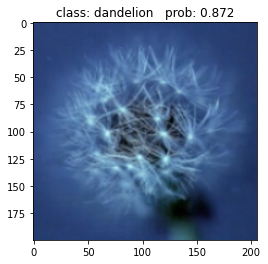

class: dandelion    prob: 0.872
class: roses        prob: 0.0359
class: sunflowers   prob: 0.0104
class: tulips       prob: 0.0206


In [3]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

import torch.nn as nn
import torch

class AlexNet(nn.Module):
    def __init__(self, num_classes=1000, init_weights=False):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(              #为了加快速度将参数减半，准确率影响不大
            nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=2),  # input[3, 224, 224]  output[48, 55, 55]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[48, 27, 27]
            nn.Conv2d(48, 128, kernel_size=5, padding=2),           # output[128, 27, 27]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[128, 13, 13]
            nn.Conv2d(128, 192, kernel_size=3, padding=1),          # output[192, 13, 13]
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),          # output[192, 13, 13]
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 128, kernel_size=3, padding=1),          # output[128, 13, 13]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[128, 6, 6]
        )
        self.classifier = nn.Sequential(                            #分类器
            nn.Dropout(p=0.5),
            nn.Linear(128 * 6 * 6, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
#-------------------------------------------

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# load image
img_path = "./1.jpg"
img = Image.open(img_path).convert('RGB') 

plt.imshow(img)
# [N, C, H, W]
img = data_transform(img)
# expand batch dimension
img = torch.unsqueeze(img, dim=0)

# read class_indict
json_path = './class_indices.json'
assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

with open(json_path, "r") as f:
    class_indict = json.load(f)

# create model
model = AlexNet(num_classes=5).to(device)

# load model weights
weights_path = "./AlexNet.pth"
assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
model.load_state_dict(torch.load(weights_path))

model.eval()
with torch.no_grad():
    # predict class
    output = torch.squeeze(model(img.to(device))).cpu()
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()

print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                             predict[predict_cla].numpy())
plt.title(print_res)
for i in range(len(predict)):
    print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                              predict[i].numpy()))
    plt.show()

#   雏菊          蒲公英         玫瑰      向日葵       郁金香
# {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}